<div class="alert alert-block alert-info">
<b>Imports:</b> Common imports for NumPy, MatplotLib, Pandas, and OS </div>

In [1]:
## Import for data generation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

<div class="alert alert-block alert-info">
<b>ML Imports:</b> Imports to execute RNN model for sequential data </div>

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from pyspark import SparkContext
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

<div class="alert alert-block alert-warning">
<b>nn_train_test() function:</b> 
    
This function takes inputs:
    
    path --> path to the repository with all your .npy file
    n_future --> number of future days of fire you want to predict (will be 1 for us)
    n_comp --> number of principal componenents you want PCA to reduce to
    n_past --> number of past days you want to consider (we can experiment with this)
    
Outputs:
    
    input_dim is set to a 1-D array of 256 ^ 2 for now! 
    x_train --> x_train in format (batch_size, timesteps, input_dim)
    y_train --> training data in format (batch_size, input_dim)
    pca_array --> an array of all of the PCA's done to the x_training data in a row. This is useful when computing the 
    inverse of the results of your neural net!
    
</div>

In [3]:
def nn_train_test(path, n_past, n_comp, n_future = 1):
    x_train_list = []
    y_train_list = []
    count = 0
    pca_array = []
    for file in os.listdir(r"{path}".format(path = path)):
        if os.path.getsize("{path}\\{file}".format(path = path, file = file)) < 100000:
            continue
        training_fire = np.load("{path}\\{file}".format(path = path, file = file))
        shape = np.array(training_fire.shape) 
        if shape[0] < n_past + n_future:
            continue
        standard_fire = np.zeros((len(training_fire), 256, 256))    
        if shape[1] > 255 or shape[2] > 255:
            standard_fire[:shape[0], :min(256, shape[1]), :min(256, shape[2])] = training_fire[:, :256, :256]
        else: 
            standard_fire[:shape[0], :shape[1], :shape[2]] = training_fire     
        n_comp = 5
        shape = standard_fire.shape
        pca_fire = np.zeros((shape[0], shape[1], n_comp))
        j = 0
        pca_dict = {}
        for day in standard_fire:
            pca = decomposition.PCA(n_components=n_comp)
            '''
            np.random.seed(134)
            print(np.random.choice(day.flatten(), 100))
            b = StandardScaler()
            b.fit(day)
            day= b.fit_transform(day)
            np.random.seed(134)
            print(np.random.choice(day.flatten(), 100))
            print('------')
            '''
            #plt.matshow(day)
            np.random.seed(134)           
            day = pca.fit_transform(day)                       
            #plt.matshow(day)            
            day3 = pca.inverse_transform(day)            
            #plt.matshow(day3)
            #print('------')            
            np.random.seed(134)            
            pca_fire[j] = day
            j += 1
            pca_dict[j] = pca       
        shape = pca_fire.shape    
        pca_fire = np.reshape(pca_fire, (shape[0], shape[1] * shape[2]))
        x_train = np.zeros((n_past, pca_fire.shape[1]))
        y_train = np.zeros((pca_fire.shape[1]))
        for i in range(0 , len(pca_fire) - n_future - n_past + 1):
            x_train_list.append(pca_fire[i : i + n_past])
            y_train_list.append(pca_fire[i + n_past: i + n_past + n_future])
            pca_array.append(pca_dict[i + n_past])
        print(len(x_train_list), len(y_train_list), len(pca_array))
    x_train = np.array(x_train_list)
    y_train = np.array(y_train_list)  

    x_train = np.reshape(x_train, (x_train.shape[0],  x_train.shape[2], x_train.shape[1]))
    y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[2]))    
    print(x_train.shape, y_train.shape, len(pca_array))
    return x_train, y_train, pca_array

<div class="alert alert-block alert-warning">
<b>RNN Inputs:</b> 
We are declaring below that the number of future days we want to predict is 1, and we can vary the number of past days
    we want to predict (I have the default as 3 for now)

</div>

In [4]:
n_future = 1
n_past = 3

<div class="alert alert-block alert-warning">
<b>Input Data for Training:</b> 
    Below, we get the input data from December 2018! 
</div>

In [8]:
%%capture 
# We are suppressing print statements and warning messages w/ above line
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\multi_day"
x_train, y_train, pca_array  = nn_train_test(path, n_past = 3, n_comp = 5, n_future =1)

<div class="alert alert-block alert-warning">
<b>Check:</b> 
    Check the shape of your x_train and y_train data
</div>

In [9]:
x_train.shape, y_train.shape

((915, 1280, 3), (915, 1280))

<div class="alert alert-block alert-success">
<b>Train your RNN:</b> Train your RNN using the training data.
    
    You might notice a lot of arbitrary values here (these are things we will want to change and test)
    - Dropout: High dropout leads to more generalization. Low dropout takes advantage of more data but overfits more easily
    - # of hidden layers: Right now, there are 2 hidden layers (+ 1 at the end). We can change this
    - # units at hidden layers: Right now, units decrease by 1 at each hidden layer. This is arbitrary and can be changed
    - optimizer --> 'adam' works but I don't know what it does
    - epochs --> We can raise this above 1 but I don't notice that changing much when I have done so
    - batch_size --> Higher batch size leads to more generalization
</div>

In [ ]:
# No need to run this if you are loading a model
regressor = Sequential()

dropout = 0
regressor.add(tf.keras.layers.Bidirectional(LSTM(units=n_past, return_sequences=True, input_shape = x_train[0].shape)))
regressor.add(Dropout(dropout))

regressor.add(LSTM(units = n_past - 1, return_sequences = True))
regressor.add(Dropout(dropout))


regressor.add(LSTM(units = n_past - 2, return_sequences = True))
regressor.add(Dropout(dropout))
'''
regressor.add(LSTM(units = n_past, return_sequences = True))
regressor.add(Dropout(dropout))
'''

regressor.add(Dense(units = n_future, activation = 'linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['acc'])

regressor.fit(x_train, y_train, epochs = 1, batch_size = 1)

<div class="alert alert-block alert-warning">
<b>Load pre-trained model:</b> 
    If you want to load a model instead, use this
</div>

In [11]:
from keras.models import load_model
model_name = 'my_model_no_scalar' ## CHANGE THIS (e.g. 'my_model') ##
regressor = load_model(model_name)

<div class="alert alert-block alert-warning">
<b>Save pre-trained model:</b> 
    If you want to save a model instead, use this
</div>

In [ ]:
model_name = ## CHANGE THIS (e.g. 'my_model') ##
regressor.save(model_name)

<div class="alert alert-block alert-warning">
<b>Input Data for Testing:</b> 
    Below, we get the input data from March 2018! 
</div>

In [17]:
path = "C:\\Users\\nico\\Desktop\\Stanford\\OneDrive - Stanford\\Courses\\CS229\\finalproject\\data\\United_States_Fires\\United_States_2018_Fires\\dec\\multi_day"
x_test, y_test, pca_array  = nn_train_test(path, n_past = 3, n_comp = 5, n_future =1)

C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

41 41 41
53 53 53


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

89 89 89


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


121 121 121


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


136 136 136


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


160 160 160
177 177 177


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

202 202 202


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


256 256 256


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

285 285 285
298 298 298


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

340 340 340


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


362 362 362
375 375 375


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


381 381 381
382 382 382
386 386 386


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


392 392 392


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


399 399 399


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


418 418 418


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


438 438 438


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


445 445 445


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


454 454 454
458 458 458


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


462 462 462


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


478 478 478


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


486 486 486


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


498 498 498


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


518 518 518
538 538 538
542 542 542


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


546 546 546


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


552 552 552
556 

C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


556 556
560 560 560


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


563 563 563
578 578 578


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


583 583 583
591 591 591


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


602 602 602
603 603 603


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


609 609 609
612 612 612


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


614 614 614
616 616 616


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

629 629 629


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


634 634 634
636 636 636


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


642 642 642


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


651 651 651


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


662 662 662


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


667 667 667
669 669 669


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


677 677 677
679 679 679


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


680 680 680
683 683 683


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


688 688 688


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


701 701 701
705 705 705


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


706 706 706
707 707 707
708 

C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


708 708
712 712 712


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


714 714 714
715 715 715


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

728 728 728
731 731 731


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


738 738 738
741 741 741


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


754 754 754
756 756 756


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


762 762 762


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

777 777 777


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


788 788 788
790 790 790


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


793 793 793


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


797 797 797
800 800 800


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


802 802 802
803 803 803


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


822 822 822
826 826 826


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


843 843 843


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\m

863 863 863
873 873 873
876 876 876


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


884 884 884
885 885 885


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


889 889 889
891 891 891


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


895 895 895
898 898 898


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


901 901 901
902 902 902


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


906 906 906
912 912 912


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


915 915 915
(915, 1280, 3) (915, 1280) 915


C:\Users\nico\miniconda3\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


<div class="alert alert-block alert-warning">
<b>Check:</b> I've noticed the first dimensions of these sometimes these don't match. They should.
</div>

In [19]:
x_test.shape, y_test.shape, len(pca_array)

((915, 1280, 3), (915, 1280), 915)

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> This makes your predictions using your model and reshapes them into a list of 2D arrays
</div>

In [20]:
from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range=(0,1)) This might be useful for making absolute predictions
predict_test = regressor.predict(x_test)
shape = predict_test.shape
nComp = 5
predict_test = np.reshape(predict_test, (shape[0], nComp,  shape[1]//nComp))

<div class="alert alert-block alert-warning">
<b> Predict Step:</b> Change the number for test number to see how well your network is doing visually
    
    Note the pca_array[i].inverse_transform()!
</div>

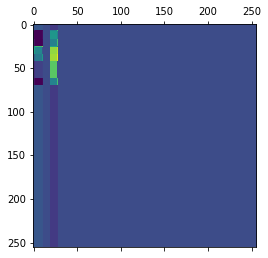

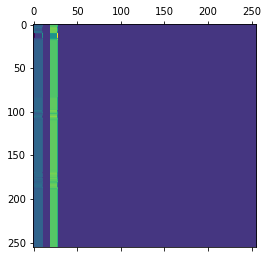

In [21]:
test_number = i = 914
d = y_test[i]
d = np.reshape(d, (256, 5))
plt.matshow(pca_array[i].inverse_transform(d))
d = predict_test[i]
d = np.reshape(d, (256, 5))
plt.matshow(pca_array[i].inverse_transform(d))